In [ ]:
import cv2
from google.colab import drive
from google.colab.patches import cv2_imshow
import numpy as np
from numpy import fft
from numpy.fft import fft2,fftshift,ifft2,ifftshift
import matplotlib.pyplot as plt
from sklearn.svm import SVR

#Enhancing a Night Time Image by manipulating its Histogram and Reducing Noise

##Creating functions for histogram matching

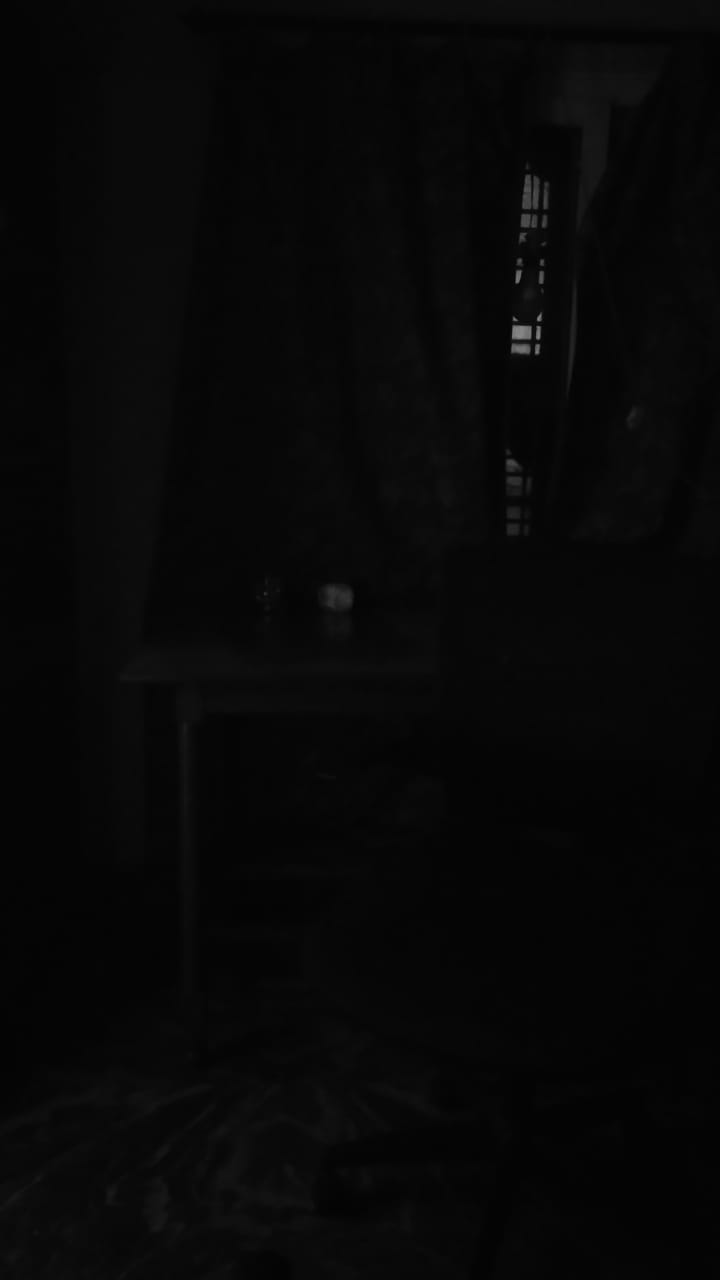

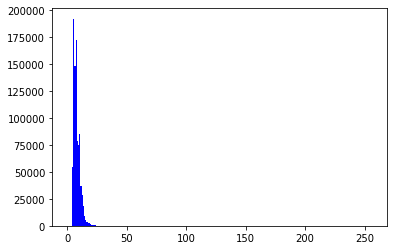

In [ ]:
# function for finding CDF with an array containing no. of pixels for each intensity value
def cdf(r):
    z=r.copy()
    for i in range(255):
        z[i+1]+=z[i] #adding previous value to the sucessive value
    z=z/z[255] # CDF lies between 0 and 1
    return z

# Function for returning target image given target histogram
def f(img,target):
    x=np.zeros(256,dtype='float')
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            x[img[i,j]]+=1 #getting the no. of pixels with a particular intensity
    z=x.copy()
    for i in range(255):
        z[i+1]+=z[i] #adding previous value to the sucessive value
    z=z/z[255] # CDF lies between 0 and 1
    s=np.interp(z,target,np.arange(256)) # s=T(r) F_s(T(r))=F_r(r)
    s=np.clip(np.round(s),0,255).astype('uint8') # intensity is discrete and in [0,255]
    s=s[img.ravel()].reshape(img.shape) #transforming r into s=T(r)
    return s

a=cv2.imread('/content/drive/MyDrive/XChair.jpeg',0)
cv2_imshow(a)
h=plt.hist(a.ravel(),bins=256,range=(0,256),color='blue')# displaying the histogram with 256 bins
plt.show()


##Histogram Matching

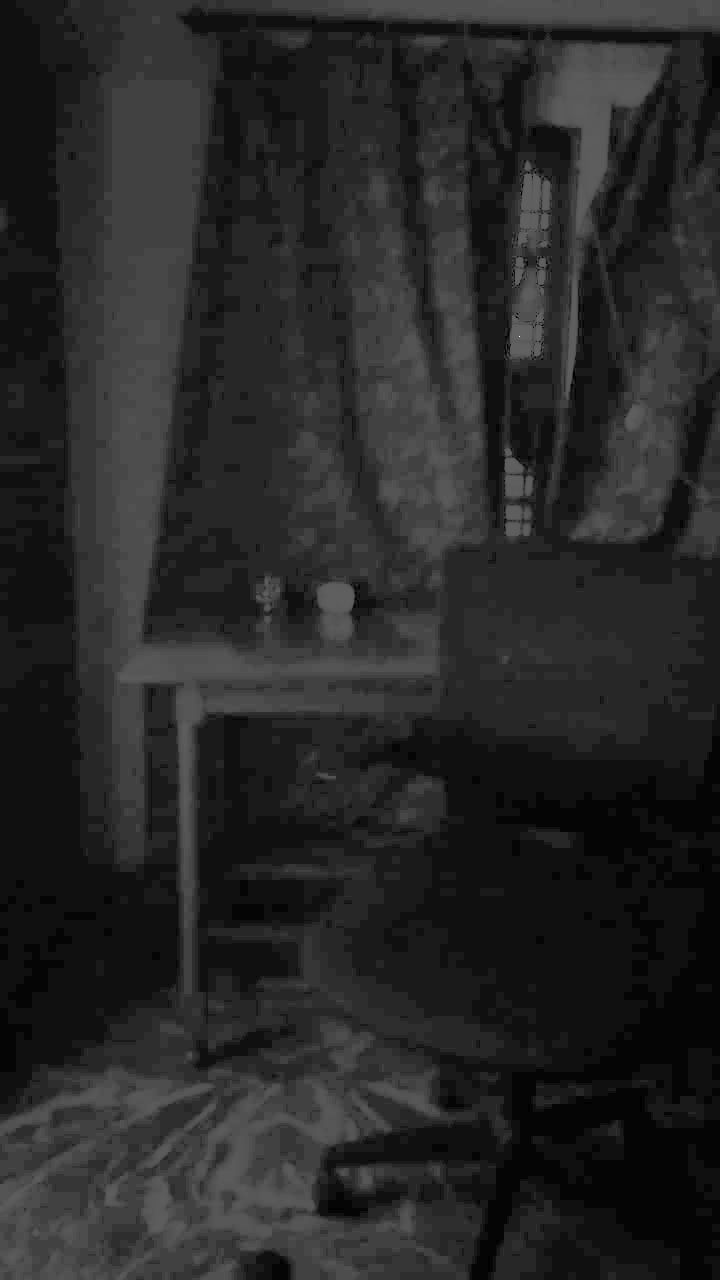

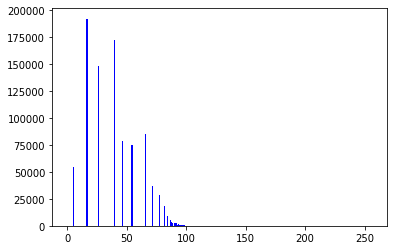

In [ ]:

x=np.arange(256)
y=x.copy()
y[0:6]=x[0:6]*100/5 #fast rising,Since max value of the histogram at 5
y[6:100]=((x[6:100]-5)*-100/95)+100 #slow decaying
y[100:256]=0
b=f(a,cdf(y)).astype('float')
h=plt.hist(b.ravel(),bins=256,range=(0,256),color='blue')
cv2_imshow(b)

##Gamma Transform and Noise removal using Guassian Blurr

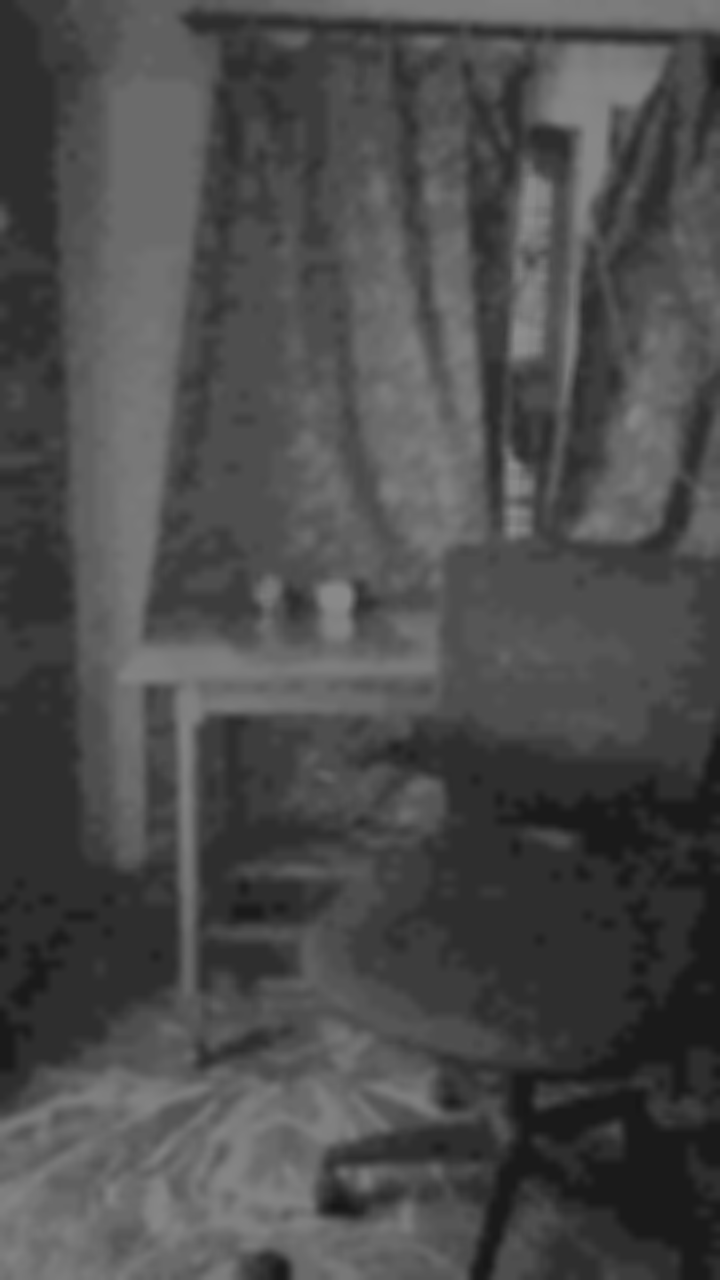

In [ ]:
b_1=((b/np.max(b))**0.7)*255  #gamma Transform
b_1=np.clip(b_1+10,0,255)
b_1=np.clip(cv2.GaussianBlur(b_1,(11,11),20),0,255) # Gaussian Blurring to reduce noise
# cv2_imshow(c_1)
cv2_imshow(b_1)

**Remarks**\
The hidden chair and table appears!

# Removal of Newspaper-ink-dot effect


##Finding the frequencies of the periodic noise using the Fourier Magnitude Spectrum and removing them using Gaussian Notch Filter

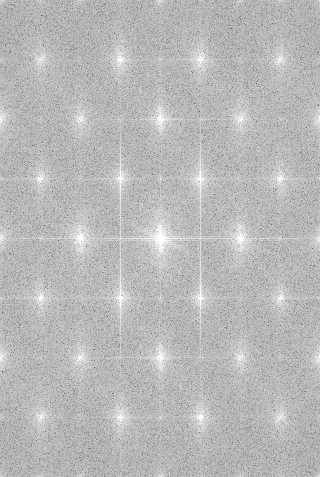

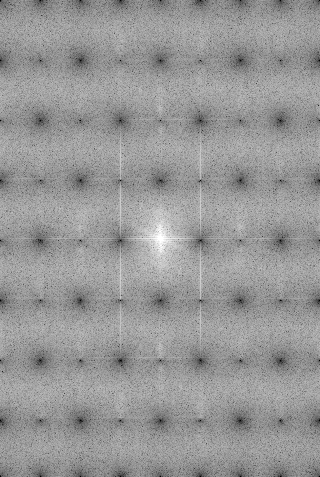

In [ ]:
from math import exp,sqrt

# to calculate distance of (u,v) from (x0,y0)
def D(u,v,x0,y0):
    t=np.sqrt(((u-x0)**2 )+ ((v-y0)**2 )) 
    return t

a=cv2.imread('/content/drive/MyDrive/newspaper-dots (1).jpg',0)
f=np.fft.fft2(a) 
f_s=np.fft.fftshift(f) #shifting the Fourier Transform so that it's origin is at the center of the image 
x=f.shape[0]//2
cv2_imshow(20*np.log(1 + np.abs(f_s)))
# We observe bright spots in the magnitude spectrum which indicate periodicity due to newspaper dots

#Finding locations of the periodic bright spots
x1=np.array([0,60,120,180,240,300,360,420,f.shape[0]-1])
y1=np.array([0,40,80,120,160,200,240,280,f.shape[1]-1])

# Using Gaussian Notch filter at those locations to supress those frequencies(except at the center to maintain brightness)
for i in range(f_s.shape[0]):
    for j in range(f_s.shape[1]):
        for n in x1:
            for m in y1:
                if(~(n==240 and m==160)):
                     f_s[i,j]=(1-exp(-(D(i,j,n,m)**2)/800))*f_s[i,j] #Gaussian Notch filter with sigma=20
cv2_imshow(20*np.log(np.abs(f_s)+1))


##Removing scan lines and certain frequencies corresponding to bright lines in the Magnitude spectrum of the FFT

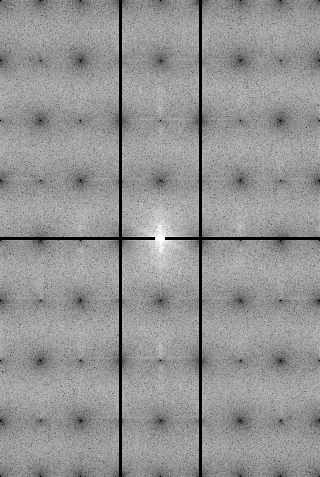

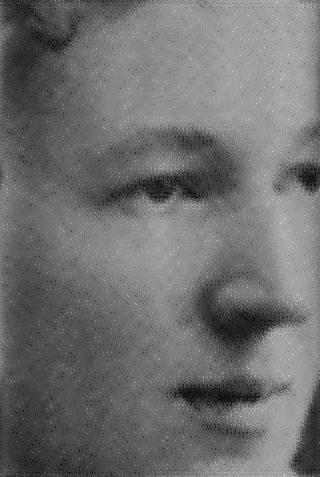

In [ ]:
f_s[:,119:122]=0
f_s[:,199:202]=0
f_s[x-1:x+2,0:155]=0
f_s[x-1:x+2,165:(f.shape[1])]=0

cv2_imshow(20*np.log(np.abs(f_s)+1))
f_1=np.fft.ifft2(np.fft.ifftshift(f_s))
f_2=np.abs(f_1)

f_2=np.clip(f_2,0,255).astype('uint8')
cv2_imshow(f_2)

#Restoring Motion Deblurred Image

##Attempt No.1
##Attempt to Restore the Motion Deblurred Image

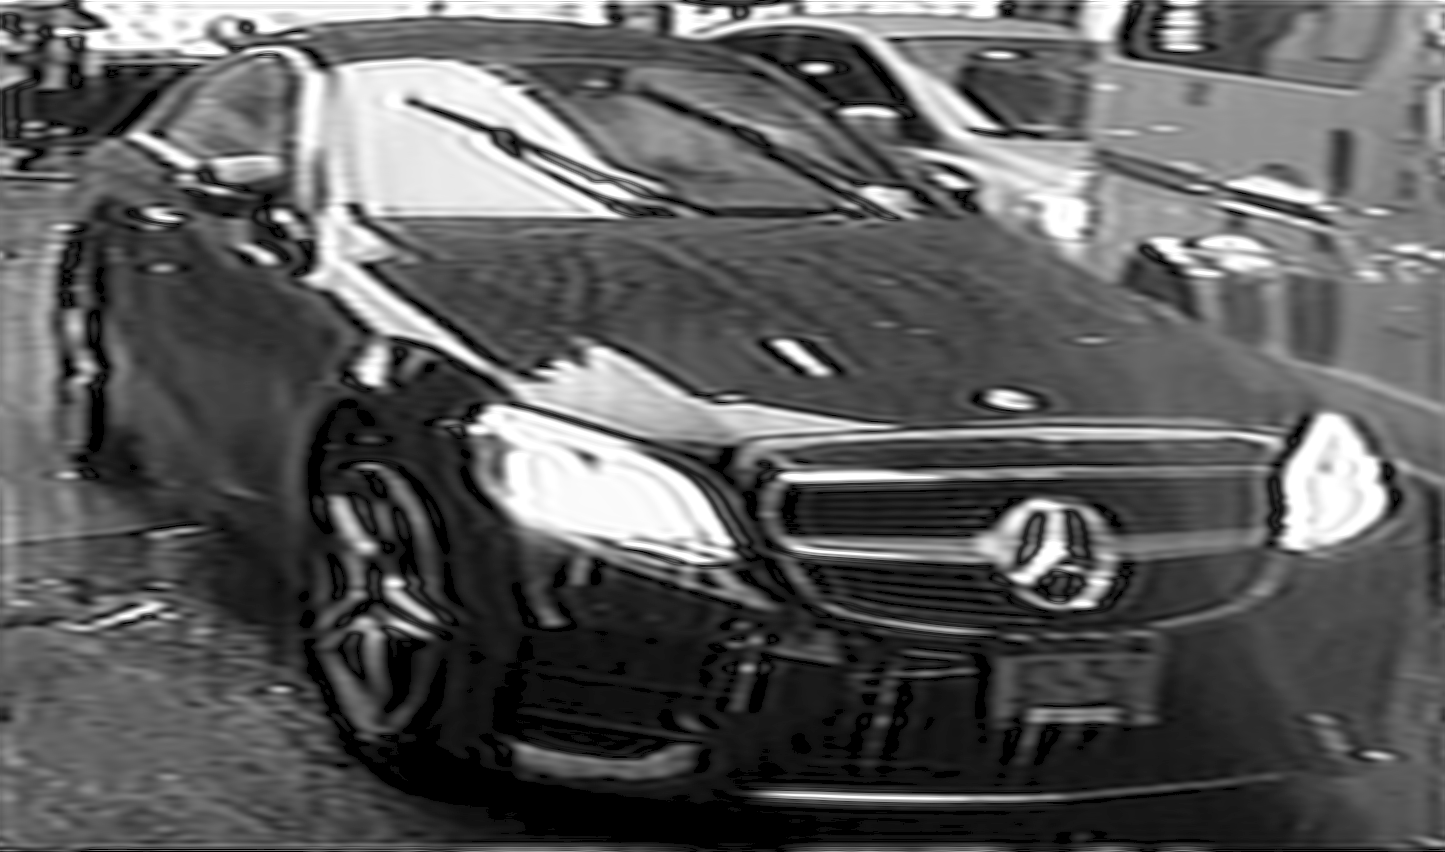

In [ ]:
#Wiener Filter
def Wiener(k,img,K):
    f=fft2(k,img.shape)
    W=np.conj(f)/((np.abs(f)**2)+K)
    I=np.abs(ifft2(W*fft2(img)))
    return I

#2-D Horizontal and vertical Gaussian Blurr
def G(a,b,img):
    g=img.copy()
    g=g.astype('float32')
    M=img.shape[0]
    N=img.shape[1]
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            g[i,j]=np.exp(-(((j-N/2))**2)/a**2 - (((i-M/2))**2)/b**2 )
    return g


img=cv2.imread('/content/drive/MyDrive/MakeNumberPlateReadable.jpg',0)
f=fftshift(fft2(img))
M=img.shape[0]
N=img.shape[1]
H=G(30,70,img) #Assuming the degradation function to 2-D Horizontal and vertical Gaussian Blurr
for i in range(M):
    for j in range(N):
        f[i,j]=f[i,j]*np.conj(H[i,j])/(np.abs((H[i,j]**2))+ 1/63) #Using Wiener Filtering


k=np.abs(ifft2(ifftshift(f)))
k=np.clip(k,0,255).astype('uint8')# Finding inverse FT 

#Now we will try to sharpen the image using Laplacian
Lp=np.array([[0,1,0],[1,-4,1],[0,1,0]])
l=cv2.Laplacian(k,ddepth = cv2.CV_16S,ksize= 3)
k=k.astype(float)
k+=0.17*l
k=np.clip(k,0,255).astype('uint8')

#Applying gamma transform and thresholding
k=(((k/np.max(k))**0.8)*255).astype('uint8')
k[k<15]=0

cv2_imshow(k)





**Important Remark**\
**Restoring the complete image is very difficult as different parts of the images get shifted differently do to the motion of different parts of the image with respect to the camera**

##Attempt No.2
**trying to use the smeared effect near the number plate to predict the kernel**

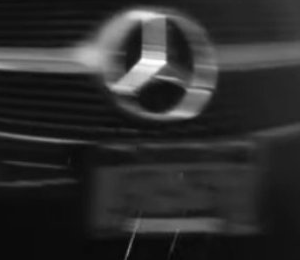

(260, 300)


(9, 25)


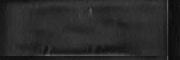

(60, 180)


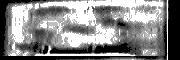

In [ ]:
#Defining Wiener Filter
def Wiener(k,img,K):
    f=fft2(k,img.shape)
    W=np.conj(f)/((np.abs(f)**2)+K)
    I=np.abs(ifft2(W*fft2(img)))
    return I

#Defining CDF
def cdf(r):
    z=r.copy()
    for i in range(255):
        z[i+1]+=z[i] #adding previous value to the sucessive value
    z=z/z[255] # CDF lies between 0 and 1
    return z

#Function for returning target image given target histogram
def fk(img,target):
    x=np.zeros(256,dtype='float')
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            x[img[i,j]]+=1 #getting the no. of pixels with a particular intensity
    z=x.copy()
    for i in range(255):
        z[i+1]+=z[i] #adding previous value to the sucessive value
    z=z/z[255] # CDF lies between 0 and 1
    s=np.interp(z,target,np.arange(256)) # s=T(r) F_s(T(r))=F_r(r)
    s=np.clip(np.round(s),0,255).astype('uint8') # intensity is discrete and in [0,255]
    s=s[img.ravel()].reshape(img.shape) #transforming r into s=T(r)
    return s
            

img=cv2.imread('/content/drive/MyDrive/MakeNumberPlateReadable.jpg',0)
img.shape
s=img[490:750,900:1200].astype('float') # Trying to find the part of image with the number plate
cv2_imshow(s)
print(s.shape)

#Trying to use the smeared part as the shape of the kernel
k=s[20:80,130:200]
k[k<180]=0
f=k[38:47,10:35]
cv2_imshow(f)
f[f<245]=0
cv2_imshow(f)
print(f.shape)

#Using a Horizontally varying Gaussian at the middle Row
kernel=np.zeros((9,25),'float')
for j in range(13):
    kernel[4,j]=12.0-j
kernel[4,:13]=np.exp(-(kernel[4,:13]**2)/20)

#Normalising the kernel
kernel=kernel/np.sum(kernel)
s=np.clip(s[160:220,80:260],0,255)

#Wiener Filtering
i=Wiener(kernel,s,1/40).astype('float64')

cv2_imshow(i)
print(i.shape)
i=i.astype('uint8')

#Histogram Equalization
i=cv2.equalizeHist(i)
i[i<50]=0
i[i>200]=255
cv2_imshow(i)


##Diagonally Varying Guassian

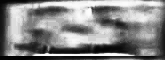

(60, 165)


In [ ]:
#Trying to use the smeared part as the shape of the kernel
kernel=np.zeros((9,25),'float')
for i in range(9):
    kernel[i,3*i]=np.exp(-((i-4)**2 + (3*i-12)**2)/0.1) # Diagonally Varying Guassian



#Zero padding
k=np.zeros((18,50),'float')
k[0:9,0:25]=kernel


#Normalising the kernel
k=k/np.sum(k)


#Wiener Filtering
i=Wiener(k,s,1/40).astype('uint8')
i=i[:,0:165]
#histogram Equalization 
i=cv2.equalizeHist(i)
cv2_imshow(i)
print(i.shape)

#Removing Subtle Scan Lines from Triton

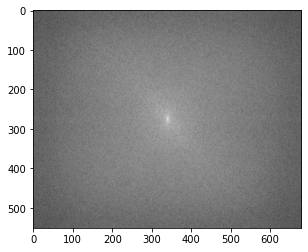

In [ ]:
a=cv2.imread('/content/drive/MyDrive/triton_voyager2.jpg').astype(float)
Y = a[:,:,0]/3 + a[:,:,1]/3  + a[:,:,2]/3 #converting into grayscale image by averaging
M=Y.shape[0]
N=Y.shape[1]
fft_Y=fftshift(fft2(Y))
plt.imshow(np.log(1+np.abs(fft_Y)),cmap='gray')
plt.show()

**We encounter no visible proof of scan lines in the magnitude spectrum of the Fourier transform!**

##Resolution
**We can split the image into 4 subparts so that the Scan Lines become more Prominent in each of the subimage's Magnitude spectrum**

###Segment 1

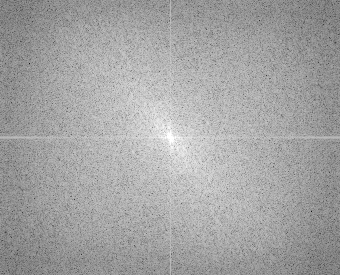

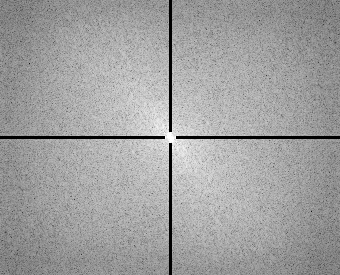

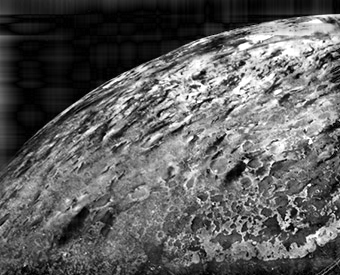

In [ ]:
f_1=fftshift(fft2(Y[0:M//2 ,0:N//2 ]))

M_1=f_1.shape[0]
N_1=f_1.shape[1]
masked_k_1=np.zeros(f_1.shape,dtype='double')        #using to mask the center of the Fourier transform to preserve average Brightness
kernel_1=np.ones(f_1.shape,dtype='double')

for i in range(M_1//2 -5,M_1//2 +6):
    for j in range(N_1//2 -5,N_1//2 +6):
        if((i-(M_1//2))**2 + (j-(N_1//2))**2 <= 60): # Hiding the center of the Fourier transform to preserve average Brightness using a circle
            masked_k_1[i,j]=1

kernel_1[(M_1//2)- 1:(M_1//2)+2,:]=0 #Horizontal Black Line
kernel_1[:,N_1//2-1:N_1//2+2]=0      #Vertical Black Line
kernel_1+=masked_k_1                 #Adding masked kernel so that its value is one for a circle of radius sqrt(60) at the center
kernel_1=np.clip(kernel_1,0,1)
cv2_imshow(20*np.log(np.abs(f_1)+1))

f_1*=kernel_1 #Multiplication with Kernel
cv2_imshow(20*np.log(np.abs(f_1)+1))

t_1=np.clip(np.abs(ifft2(ifftshift(f_1))),0,255).astype('uint8')

cv2_imshow(t_1)

###Segment 2

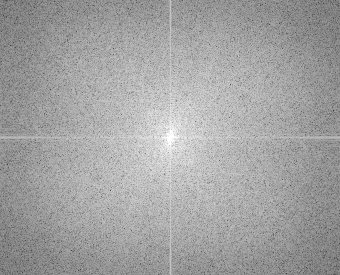

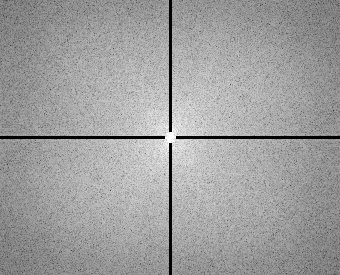

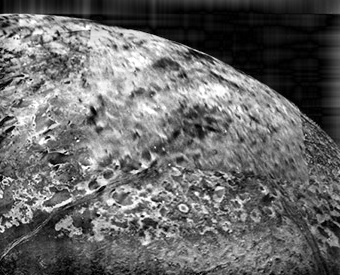

In [ ]:
a=cv2.imread('/content/drive/MyDrive/triton_voyager2.jpg').astype(float)
Y = a[:,:,0]/3 + a[:,:,1]/3  + a[:,:,2]/3 
M=Y.shape[0]
N=Y.shape[1]
f_2=fftshift(fft2(Y[0:M//2 ,N//2:N ]))

M_2=f_2.shape[0]
N_2=f_2.shape[1]
masked_k_2=np.zeros(f_2.shape,dtype='double') #using to mask the center of the Fourier transform to preserve average Brightness
kernel_2=np.ones(f_2.shape,dtype='double')

for i in range(M_2//2 -5,M_2//2 +6):
    for j in range(N_2//2 -5,N_2//2 +6):
        if((i-(M_2//2))**2 + (j-(N_2//2))**2 <= 60):
            masked_k_2[i,j]=1

kernel_2[(M_2//2)- 1:(M_2//2)+2,:]=0 #Horizontal Black Line
kernel_2[:,N_2//2-1:N_2//2+2]=0     #Vertical Black Line
kernel_2+=masked_k_2                #Adding masked kernel so that its value is one for a circle of radius sqrt(60) at the center

kernel_2=np.clip(kernel_2,0,1)
cv2_imshow(20*np.log(np.abs(f_2)+1))
f_2*=kernel_2

cv2_imshow(20*np.log(np.abs(f_2)+1))
t_2=np.clip(np.abs(ifft2(ifftshift(f_2))),0,255).astype('uint8')
cv2_imshow(t_2)


###Segment 3

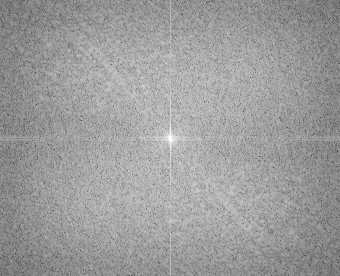

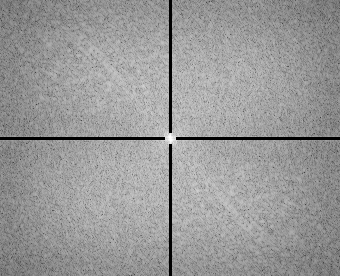

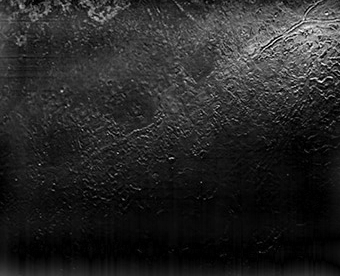

In [ ]:
a=cv2.imread('/content/drive/MyDrive/triton_voyager2.jpg').astype('float')
Y = a[:,:,0]/3 + a[:,:,1]/3  + a[:,:,2]/3
M=Y.shape[0]
N=Y.shape[1]
f_3=fftshift(fft2(Y[M//2:M ,0:N//2 ]))
cv2_imshow(20*np.log(np.abs(f_3)+1))
M_3=f_3.shape[0]
N_3=f_3.shape[1]

masked_k_3=np.zeros(f_3.shape,dtype='double')
kernel_3=np.ones(f_3.shape,dtype='double')

for i in range(M_3//2 -5,M_3//2 +6):
    for j in range(N_3//2 -5,N_3//2 +6):
        if((i-(M_3//2))**2 + (j-(N_3//2))**2 <= 60):
            masked_k_3[i,j]=1

kernel_3[(M_3//2)- 1:(M_3//2)+2,:]=0
kernel_3[:,N_3//2-1:N_3//2+2]=0
kernel_3+=masked_k_3                        #Adding masked kernel so that its value is one for a circle of radius sqrt(60) at the center
kernel_3=np.clip(kernel_3,0,1)

f_3*=kernel_3                               #Multiplication with Kernel
cv2_imshow(20*np.log(np.abs(f_3)+1))

t_3=np.abs(ifft2(ifftshift(f_3)))
t_3=np.clip(np.abs(ifft2(ifftshift(f_3))),0,255).astype('uint8')
t_3=((t_3/np.max(t_3))**0.9)*255            #Applying Gamma Transform
cv2_imshow(t_3)


###Segment 4

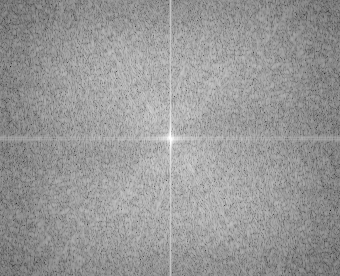

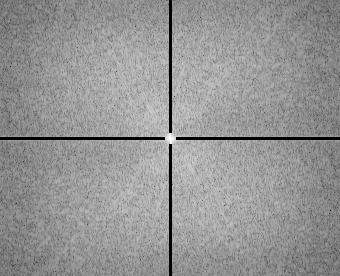

In [ ]:
a=cv2.imread('/content/drive/MyDrive/triton_voyager2.jpg').astype('float')
Y = a[:,:,0]/3 + a[:,:,1]/3  + a[:,:,2]/3
M=Y.shape[0]
N=Y.shape[1]

f_4=fftshift(fft2(Y[M//2:M ,N//2:N ]))
cv2_imshow(20*np.log(np.abs(f_4)+1))
M_4=f_4.shape[0]
N_4=f_4.shape[1]

masked_k_4=np.zeros(f_4.shape,dtype='double')
kernel_4=np.ones(f_4.shape,dtype='double')

for i in range(M_4//2 -5,M_4//2 +6):
    for j in range(N_4//2 -5,N_4//2 +6):
        if((i-(M_4//2))**2 + (j-(N_4//2))**2 <= 60):
            masked_k_4[i,j]=1

kernel_4[(M_4//2)- 1:(M_4//2)+2,:]=0
kernel_4[:,N_4//2-1:N_4//2+2]=0
kernel_4+=masked_k_4
kernel_4=np.clip(kernel_4,0,1)

f_4*=kernel_4
cv2_imshow(20*np.log(np.abs(f_4)+1))

t_4=np.abs(ifft2(ifftshift(f_4)))
t_4=np.clip(np.abs(ifft2(ifftshift(f_4))),0,255).astype('uint8')
t_4=((t_4/np.max(t_4))**0.9)*255        #Applying Gamma Transform
cv2_imshow(t_4)

##Concatenating all the 4 subimages after removing Scan Lines and appropriate Histogram equalization

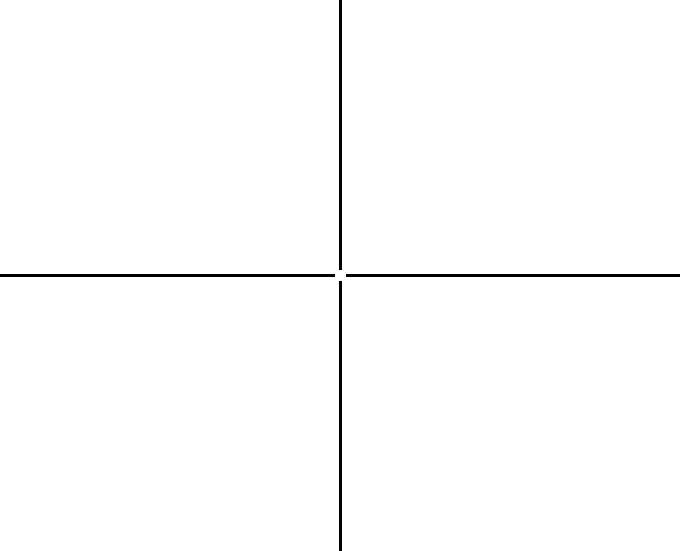

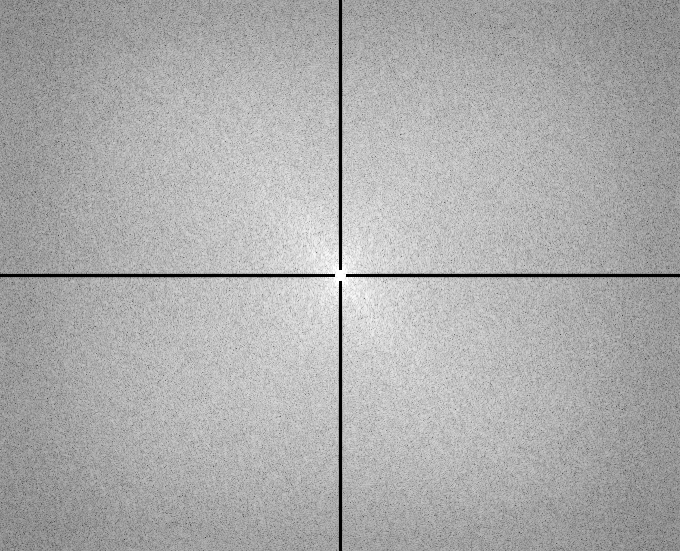

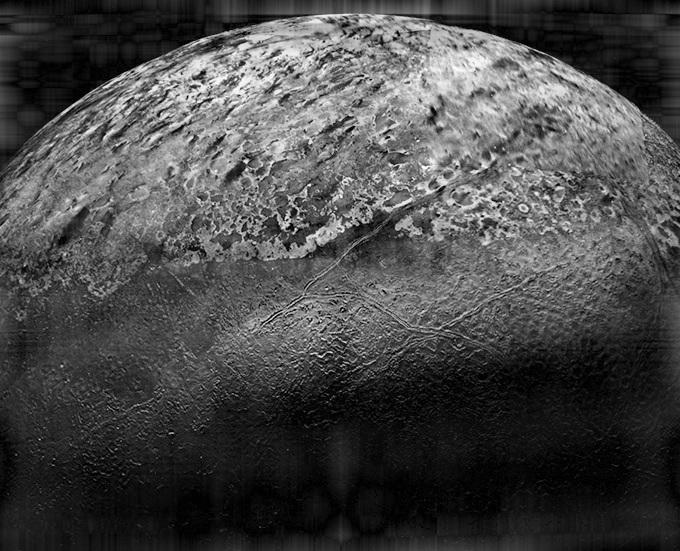

In [ ]:
T=np.concatenate((t_1,t_2),axis=1).astype('float64')        #Concatenating along Columns
T_1=np.concatenate((t_3,t_4),axis=1).astype('float64')      #Concatenating along Columns     
T=np.concatenate((T,T_1),axis=0).astype('float64')          #Concatenating along Rows

#Removing Scan Lines from the concatenated image
f=fftshift(fft2(T))
mask=np.zeros(f.shape)
ker=np.ones(f.shape)


for i in range(M//2 -5,M//2 +6):
    for j in range(N//2 -5,N//2 +6):
        if((i-(M//2))**2 + (j-(N//2))**2 <= 60):
            mask[i,j]=1

ker[(M//2)- 1:(M//2)+2,:]=0
ker[:,N//2-1:N//2+2]=0
ker+=mask                       #Adding masked kernel so that its value is one for a circle of radius sqrt(60) at the center
ker=np.clip(ker,0,1).astype('float64')
cv2_imshow(ker*255)
f*=ker
T=np.abs(ifft2(ifftshift(f))).astype('float')
T=((T/np.max(T))**0.83)*255
cv2_imshow(20*np.log(1+np.abs(f)))
cv2_imshow(T)


## Final Image obtained By Maintaining the Colour Ratio if the Original Image is divided into 4 Sections

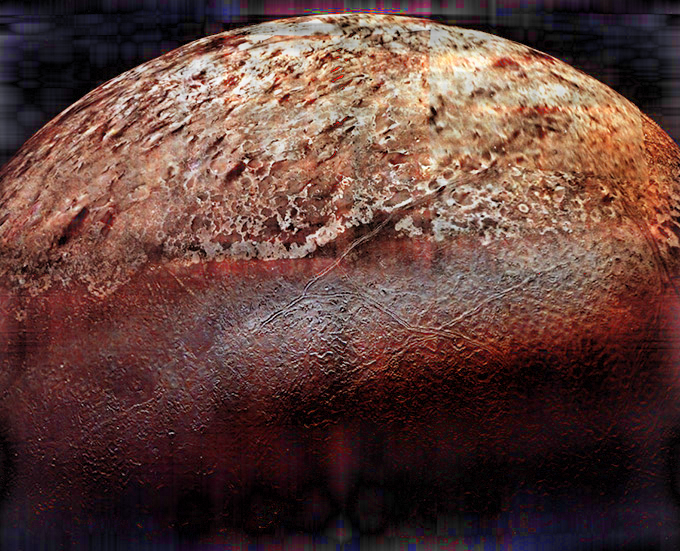

In [ ]:
a[a==0]=1
a=a.astype('float64')

#Finding out R:G:B Ratio in image 'a' using x,y,z
x=a[:,:,1]/a[:,:,0]
y=a[:,:,2]/a[:,:,0]
z=a[:,:,2]/a[:,:,1]

#Finding out new R,G,B values
r=T/(0.33333 + 0.33333*x  + 0.33333*y )
g=T/(0.33333/x + 0.33333 + 0.33333*z)
b=T/(0.33333/y + 0.33333/z + 0.33333)

copy=a.copy()
copy[:,:,0]=r
copy[:,:,1]=g
copy[:,:,2]=b
cv2_imshow(copy)

##Final Image Obtained by Segmenting into 2 Sections Vertically by same procedure

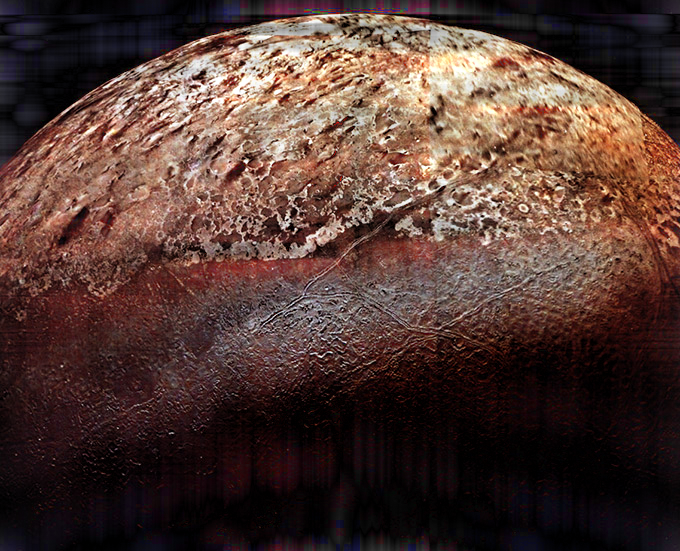

In [ ]:
a[a==0]=1
a=a.astype('float64')
x=a[:,:,1]/a[:,:,0]
y=a[:,:,2]/a[:,:,0]
z=a[:,:,2]/a[:,:,1]
r=T/(0.33333 + 0.33333*x  + 0.33333*y )
g=T/(0.33333/x + 0.33333 + 0.33333*z)
b=T/(0.33333/y + 0.33333/z + 0.33333)
copy=a.copy()
copy[:,:,0]=r
copy[:,:,1]=g
copy[:,:,2]=b
cv2_imshow(copy)
# for i in range(a.shape[0]):
#     for j in range(a.shape[1]):
#         if(np.round(a[i,j,1]/a[i,j,2],2)!=np.round(copy[i,j,1]/copy[i,j,2],2)):
#             print(np.round(a[i,j,1]/a[i,j,2],2),np.round(copy[i,j,1]/copy[i,j,2],2))

#ML-based image restoration

##Good Images


(500, 500) (500, 500) (500, 500) (500, 500) (431, 500)


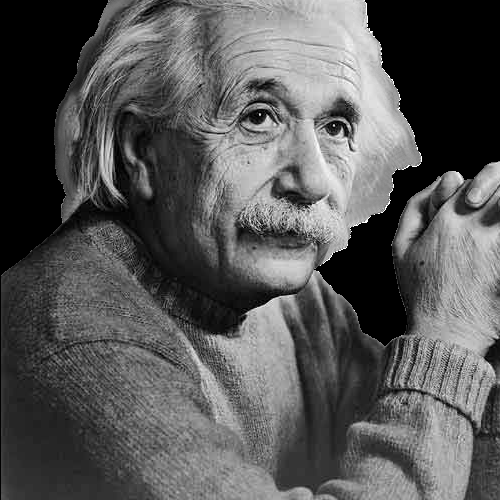

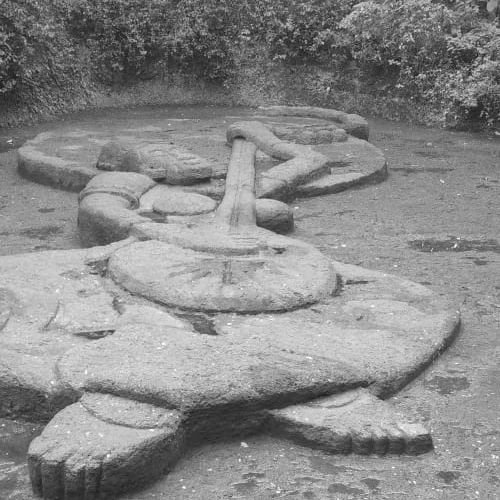

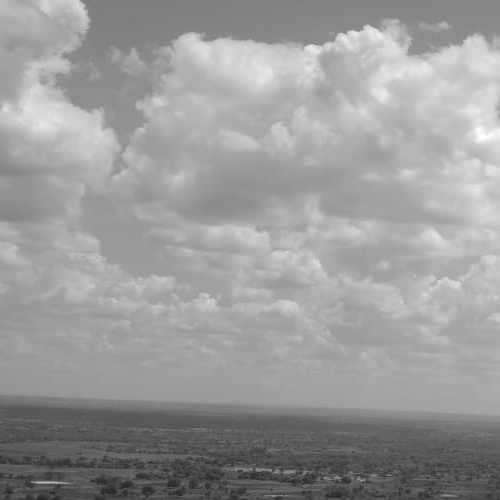

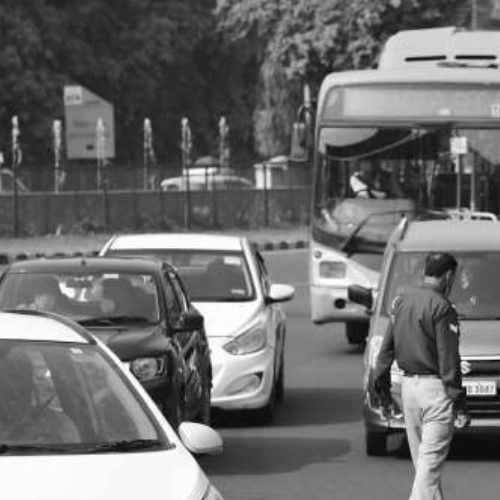

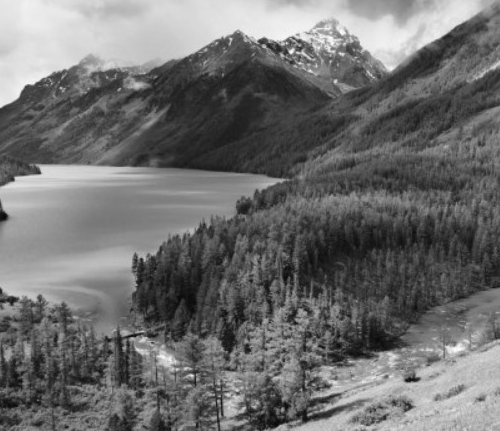

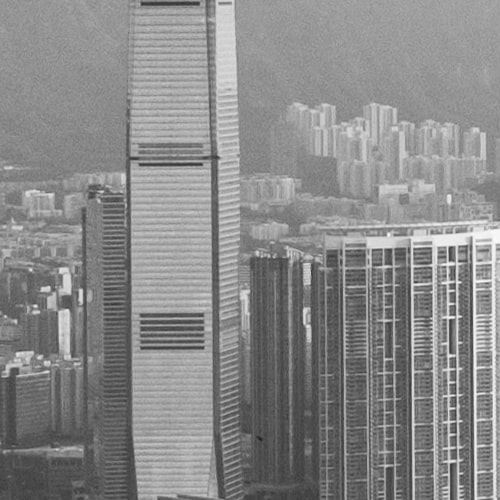

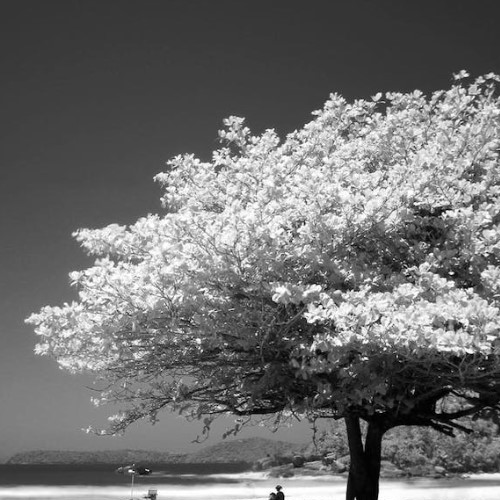

In [198]:
g_1=cv2.imread('/content/drive/MyDrive/einstien.png',0)[50:550,0:500].astype('float')
g_2=cv2.imread('/content/drive/MyDrive/Snake.jpeg',0)[150:650,200:700].astype('float')
g_3=cv2.imread('/content/drive/MyDrive/Clouds.jpeg',0)[200:700,100:600].astype('float')
g_5=cv2.imread('/content/drive/MyDrive/mountain.jpg',0)[100:600,100:600].astype('float')
g_4=cv2.imread('/content/drive/MyDrive/delhi.jpg',0)[0:500,0:500].astype('float')

g_6=cv2.imread('/content/drive/MyDrive/Buildings.jpg',0)[1000:1500,800:1300].astype('float')
g_7=cv2.imread('/content/drive/MyDrive/flwr.jpg',0)[0:500,0:500].astype('float')
print(g_1.shape,g_2.shape,g_3.shape,g_4.shape,g_5.shape)
W=11
cv2_imshow(g_1)
cv2_imshow(g_2)
cv2_imshow(g_3)
cv2_imshow(g_4)
cv2_imshow(g_5)
cv2_imshow(g_6)
cv2_imshow(g_7)

##Bad Images from Collection and their degradation process

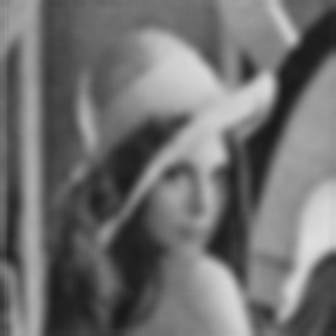

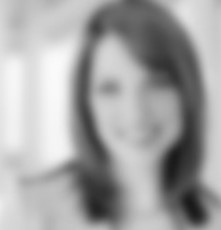

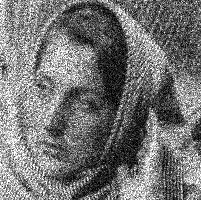

In [199]:
degraded_1=cv2.imread('/content/drive/MyDrive/Noisy-blurred-Lena-image-7-7-uniform-blur-10-dB-uniform-noise.png',0).astype('float')
degraded_1=np.clip(cv2.GaussianBlur(degraded_1,(13,13),10).astype('float'),0,255)
#degraded_1 is quite blurred and has slightly low contrst too

degraded_2=cv2.imread('/content/drive/MyDrive/women.jpg',0).astype('float')
#degraded 2 is quite blurred and smoothened and the edges are hardly visible

degraded_3=cv2.imread('/content/drive/MyDrive/Example-of-denoising-results-of-a-part-of-the-image-Cameraman-a-Noisy-image-Peak5.png',0).astype('float')
#degraded_3 is extremely noisy with a lot of gaussian noise and with a bit of salt-pepper noise
cv2_imshow(degraded_1)
cv2_imshow(degraded_2)
cv2_imshow(degraded_3)

##Taking on the Challenge of Image Restoration Using ML

### Degrading the Good Images

In [200]:
b_2=cv2.imread('/content/drive/MyDrive/Blurr.jpeg',0)

#Guassian Blurring g_1
d_1=np.clip(cv2.GaussianBlur(g_1,(13,13),10).astype('float'),0,255).astype('float')
d_1=np.clip(d_1+np.random.normal(0,0.2,g_1.shape)*255,0,255).astype('float') #Adding gaussian Noise

#Adding gaussian Noise and a bit of salt-pepper noise to g_2
d_2=np.clip(g_2+np.random.normal(0,0.3,g_2.shape)*255,0,255).astype('float') #Guassian Noise

#Salt Pepper Noise
for i,j in zip(np.random.randint(0,g_2.shape[0],(g_2.shape[0]*g_2.shape[1])//50),np.random.randint(0,g_2.shape[1],(g_2.shape[0]*g_2.shape[1])//50)):
    if(np.random.random()>=0.5):
        d_2[i,j]=255
    else:
        d_2[i,j]=0
d_2=np.clip(cv2.GaussianBlur(d_2,(11,11),60).astype('float'),0,255).astype('float')

#Gaussian Blurring the image and then adding Gaussian noise
d_3=np.clip(cv2.GaussianBlur(g_3,(13,13),20).astype('float'),0,255).astype('float')
d_3=np.clip(g_3+np.random.normal(0,0.2,g_3.shape)*255,0,255).astype('float')

#Blurring g_4 with a small sigma
d_4=np.clip(cv2.GaussianBlur(g_4,(13,13),5).astype('float'),0,255)
#d_4=np.clip(d_4+np.random.normal(0,0.07,d_4.shape)*255,0,255).astype('float')

#Reducing contrast of g_5 and the using some sort of an averaging kernel
g_5=cv2.imread('/content/drive/MyDrive/mountain.jpg',0).astype('float')
g_5=np.clip(g_5*0.9,0,255)
d_5=g_5.copy()
kl=np.ones((17,17),'float')
kl[8,8]=4
kl*=1/292
d_5=cv2.filter2D(d_5,-1,kl)


#Validation Data det
#Guassian Blurring g_1
d_6=np.clip(cv2.GaussianBlur(g_6,(13,13),6).astype('float'),0,255).astype('float')

#adding Gaussian noise
d_7=np.clip(g_7+np.random.normal(0,0.2,g_7.shape)*255,0,255).astype('float')




###Training the ML Model
**Creating a list x of size NxW where N is the number of patches of size WxWx1 mined from the degraded versions of the training images.  Creating a list y of size Nx1 associated with the original central pixel** 

In [ ]:
x=[]
y=[]

l_1=[d_1,d_2,d_3,d_4,d_5] #taking empty x,y lists so that it is easy to append them
l_2=[g_1,g_2,g_3,g_4,g_5]


for z,t in zip(l_1,l_2):
    #Mining only a few patches from random locations from each image, instead of mining all possible patches
    for i,j in zip(np.random.randint(W,z.shape[0]-W,(z.shape[0]*z.shape[1])//5000),np.random.randint(W,z.shape[1]-W,(z.shape[0]*z.shape[1])//5000)):
        x.append(z[i-W//2:i+1+W//2,j-W//2:j+1+W//2])
        y.append(t[i,j]-z[i,j]) #predicting the residual of the difference between the original and degraded central pixel
x=np.array(x)
y=np.array(y)
#Train a regression model 
regressor = SVR(kernel='rbf', C=100, epsilon=0.1, gamma='scale' ) 
x=x.reshape((x.shape[0],W**2))
regressor.fit(x,y)





SVR(C=100)

###Varying the hyperparameters to check the performance on the validation dataset

In [ ]:
l_3=[d_6,d_7]
l_4=[g_6,g_7]

x_1=[] #taking empty x_1,y_1 lists so that it is easy to append them
y_1=[]

for z,t in zip(l_3,l_4):
    for i,j in zip(np.random.randint(W,z.shape[0]-W,(z.shape[0]*z.shape[1])//5000),np.random.randint(W,z.shape[1]-W,(z.shape[0]*z.shape[1])//5000)):
            #Mining only a few patches from random locations from each image, instead of mining all possible patches
        x_1.append(z[i-W//2:i+1+W//2,j-W//2:j+1+W//2])
        y_1.append(t[i,j]-z[i,j]) #predicting the residual of the difference between the original and degraded central pixel

x_1=np.array(x_1)
y_1=np.array(y_1)

x_1=x_1.reshape((x_1.shape[0],W**2))
y_pred = regressor.predict(x_1)
mse_error=(np.sum((y_pred-y_1)**2)) #Calculating MSE error
print(mse_error)
#Varying the parameters for minimum MSE


126446.81962189081


##The ML Algorithm tries its best to detect edges and make the edges prominent of a Blurred Image!!

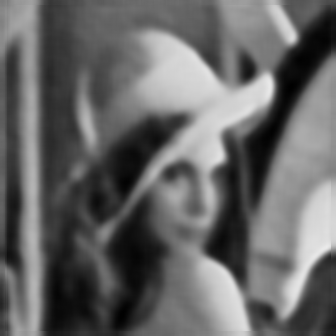

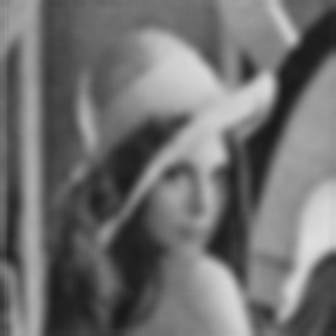

In [ ]:
deg=cv2.imread('/content/drive/MyDrive/Noisy-blurred-Lena-image-7-7-uniform-blur-10-dB-uniform-noise.png',0).astype('float')
deg=np.clip(cv2.GaussianBlur(deg,(13,13),10).astype('float'),0,255)
pred=deg.copy()
for i in range(W//2,deg.shape[0]-W//2):

    for j in range(W//2,deg.shape[1]-W//2):
        x_input=deg[i-W//2:i+W//2+1,j-W//2:j+1+W//2].reshape(1,W*W) #Reshaping the WxW window into a 1 row 2-D array
        y_out=regressor.predict(x_input) #predicting the error using the Model
        pred[i,j]+=y_out #Adding the predicted error to the pixel value

pred=((pred-np.min(pred))/np.max(pred))*255 #linear function ranging from 0-255
cv2_imshow(pred)
cv2_imshow(deg)

##Significant Noise Supression by reduction in Gaussian Noise!

[-47.06990007]
[-41.01336691]
[-42.04835655]
[-41.74622939]
[-42.3337842]
[-43.71737662]
[-42.42986302]
[-48.57244627]
[44.08745913]
[-42.85804122]
[-50.42340261]
[-40.30944756]
[-42.99050569]
[-41.07745982]
[-42.77851771]
[-40.98549942]
[-41.32670131]
[-40.47890637]
[-40.150868]
[-42.3811814]
[-42.26734692]
[-43.73554483]
[-45.99012103]
[-43.55271176]
[43.99063334]
[44.26702081]
[-40.15627341]
[-40.48770363]
[-40.70344779]
[68.32749947]
[-41.75962318]
[-41.41921876]
[41.27761333]
[-43.30837005]
[-43.86857977]
[-40.32178286]
[-42.57272361]
[-46.07599626]
[-42.37231672]
[-40.32699659]
[-46.24362499]
[48.54119851]
[-40.97798738]
[-40.23231949]
[-41.90914537]
[45.86942795]
[-40.17925062]
[43.80112941]
[-46.69484617]
[-43.98483685]
[-42.63989121]
[-41.24802244]


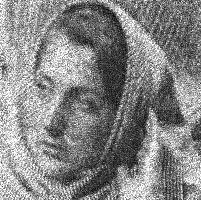

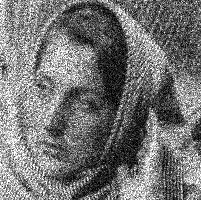

In [ ]:
deg=cv2.imread('/content/drive/MyDrive/Example-of-denoising-results-of-a-part-of-the-image-Cameraman-a-Noisy-image-Peak5.png',0).astype('float')
# deg=np.clip(cv2.GaussianBlur(deg,(13,13),10).astype('float'),0,255)
pred=deg.copy()
for i in range(W//2,deg.shape[0]-W//2):

    for j in range(W//2,deg.shape[1]-W//2):
        x_input=deg[i-W//2:i+W//2+1,j-W//2:j+1+W//2].reshape(1,W*W) #Reshaping the WxW window into a 1 row 2-D array
        y_out=regressor.predict(x_input) #predicting the error using the Model
        if(abs(y_out)>40):
            print(y_out)
        pred[i,j]+=y_out    #Adding the predicted error to the pixel value

pred=((pred-np.min(pred))/np.max(pred))*255
cv2_imshow(pred)
cv2_imshow(deg)


##Deblurring an Image


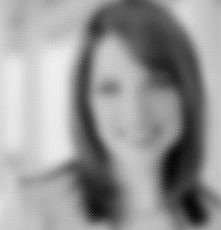

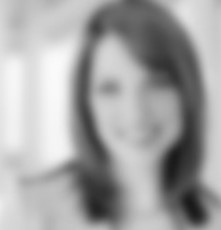

In [ ]:
deg=cv2.imread('/content/drive/MyDrive/women.jpg',0).astype('float')
pred=deg.copy()
for i in range(W//2,deg.shape[0]-W//2,3):
    for j in range(W//2,deg.shape[1]-W//2,3):
        x_input=deg[i-W//2:i+W//2+1,j-W//2:j+1+W//2].reshape(1,W*W) #Reshaping the WxW window into a 1 row 2-D array
        y_out=regressor.predict(x_input)    #predicting the error using the Model
        pred[i,j]+=y_out 
pred=((pred-np.min(pred))/np.max(pred))*255
pred=np.clip(pred,0,255)
cv2_imshow(pred)
cv2_imshow(deg)

**If we zoom on the restored image we can see that the Model has tried to make the edges prominent by increasing the pixel intensities at certain parts of the face**

##Value of W
**By using various odd values of W like 11,5,31,51(by Trial and error) I concluded that a value of W=11 is suited the best possibly because the 11x11 window isn't too low to neglect the course changes neither too big to neglect the fine changes(W=31 is also a good option but to me W=11 seems to be better)** 

##Training the ML model with W=51

In [202]:
W=51
x=[]
y=[]

l_1=[d_1,d_2,d_3,d_4,d_5] #taking empty x,y lists so that it is easy to append them
l_2=[g_1,g_2,g_3,g_4,g_5]


for z,t in zip(l_1,l_2):
    #Mining only a few patches from random locations from each image, instead of mining all possible patches
    for i,j in zip(np.random.randint(W,z.shape[0]-W,(z.shape[0]*z.shape[1])//5000),np.random.randint(W,z.shape[1]-W,(z.shape[0]*z.shape[1])//5000)):
        x.append(z[i-W//2:i+1+W//2,j-W//2:j+1+W//2])
        y.append(t[i,j]-z[i,j]) #predicting the residual of the difference between the original and degraded central pixel
x=np.array(x)
y=np.array(y)
#Train a regression model 
regressor = SVR(kernel='rbf', C=100, epsilon=0.1, gamma='scale' ) 
x=x.reshape((x.shape[0],W**2))
regressor.fit(x,y)

SVR(C=100)

###Validation by using W=51

In [203]:
l_3=[d_6,d_7]
l_4=[g_6,g_7]

x_1=[] #taking empty x_1,y_1 lists so that it is easy to append them
y_1=[]

for z,t in zip(l_3,l_4):
    for i,j in zip(np.random.randint(W,z.shape[0]-W,(z.shape[0]*z.shape[1])//5000),np.random.randint(W,z.shape[1]-W,(z.shape[0]*z.shape[1])//5000)):
            #Mining only a few patches from random locations from each image, instead of mining all possible patches
        x_1.append(z[i-W//2:i+1+W//2,j-W//2:j+1+W//2])
        y_1.append(t[i,j]-z[i,j]) #predicting the residual of the difference between the original and degraded central pixel

x_1=np.array(x_1)
y_1=np.array(y_1)

x_1=x_1.reshape((x_1.shape[0],W**2))
y_pred = regressor.predict(x_1)
mse_error=(np.sum((y_pred-y_1)**2)) #Calculating MSE error
print(mse_error)
#Varying the parameters for minimum MSE

131509.06132788613


###Artificial looking image obtained for the degraded image
**The finer details are not enhanced**

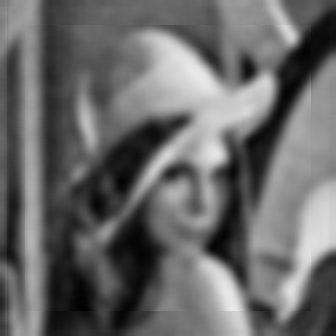

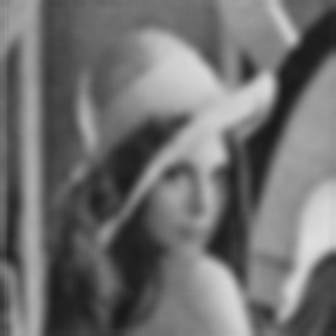

In [204]:
deg=cv2.imread('/content/drive/MyDrive/Noisy-blurred-Lena-image-7-7-uniform-blur-10-dB-uniform-noise.png',0).astype('float')
deg=np.clip(cv2.GaussianBlur(deg,(13,13),10).astype('float'),0,255)
pred=deg.copy()
for i in range(W//2,deg.shape[0]-W//2):

    for j in range(W//2,deg.shape[1]-W//2):
        x_input=deg[i-W//2:i+W//2+1,j-W//2:j+1+W//2].reshape(1,W*W) #Reshaping the WxW window into a 1 row 2-D array
        y_out=regressor.predict(x_input) #predicting the error using the Model
        pred[i,j]+=y_out #Adding the predicted error to the pixel value

pred=((pred-np.min(pred))/np.max(pred))*255 #linear function ranging from 0-255
cv2_imshow(pred)
cv2_imshow(deg)

##Training the ML Model with W=5

In [205]:
W=5
x=[]
y=[]

l_1=[d_1,d_2,d_3,d_4,d_5] #taking empty x,y lists so that it is easy to append them
l_2=[g_1,g_2,g_3,g_4,g_5]


for z,t in zip(l_1,l_2):
    #Mining only a few patches from random locations from each image, instead of mining all possible patches
    for i,j in zip(np.random.randint(W,z.shape[0]-W,(z.shape[0]*z.shape[1])//5000),np.random.randint(W,z.shape[1]-W,(z.shape[0]*z.shape[1])//5000)):
        x.append(z[i-W//2:i+1+W//2,j-W//2:j+1+W//2])
        y.append(t[i,j]-z[i,j]) #predicting the residual of the difference between the original and degraded central pixel
x=np.array(x)
y=np.array(y)
#Train a regression model 
regressor = SVR(kernel='rbf', C=100, epsilon=0.1, gamma='scale' ) 
x=x.reshape((x.shape[0],W**2))
regressor.fit(x,y)

SVR(C=100)

###Validation with W=51

In [206]:
l_3=[d_6,d_7]
l_4=[g_6,g_7]

x_1=[] #taking empty x_1,y_1 lists so that it is easy to append them
y_1=[]

for z,t in zip(l_3,l_4):
    for i,j in zip(np.random.randint(W,z.shape[0]-W,(z.shape[0]*z.shape[1])//5000),np.random.randint(W,z.shape[1]-W,(z.shape[0]*z.shape[1])//5000)):
            #Mining only a few patches from random locations from each image, instead of mining all possible patches
        x_1.append(z[i-W//2:i+1+W//2,j-W//2:j+1+W//2])
        y_1.append(t[i,j]-z[i,j]) #predicting the residual of the difference between the original and degraded central pixel

x_1=np.array(x_1)
y_1=np.array(y_1)

x_1=x_1.reshape((x_1.shape[0],W**2))
y_pred = regressor.predict(x_1)
mse_error=(np.sum((y_pred-y_1)**2)) #Calculating MSE error
print(mse_error)
#Varying the parameters for minimum MSE

62018.6668404634


###Restoration with W=51

**For a Value of W=5 the finer details are no doubt enhanced but the course details are not refined and thus as a whole there is lesser enhancement when compared to W=11**

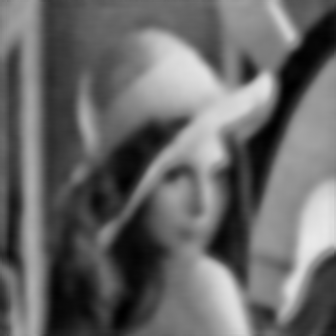

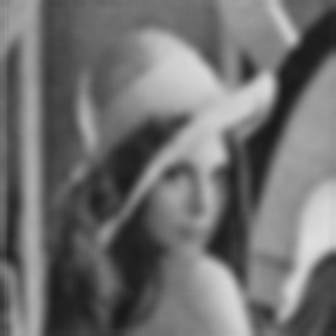

In [207]:
deg=cv2.imread('/content/drive/MyDrive/Noisy-blurred-Lena-image-7-7-uniform-blur-10-dB-uniform-noise.png',0).astype('float')
deg=np.clip(cv2.GaussianBlur(deg,(13,13),10).astype('float'),0,255)
pred=deg.copy()
for i in range(W//2,deg.shape[0]-W//2):

    for j in range(W//2,deg.shape[1]-W//2):
        x_input=deg[i-W//2:i+W//2+1,j-W//2:j+1+W//2].reshape(1,W*W) #Reshaping the WxW window into a 1 row 2-D array
        y_out=regressor.predict(x_input) #predicting the error using the Model
        pred[i,j]+=y_out #Adding the predicted error to the pixel value

pred=((pred-np.min(pred))/np.max(pred))*255 #linear function ranging from 0-255
cv2_imshow(pred)
cv2_imshow(deg)

##Training with W=31

In [208]:
W=31
x=[]
y=[]

l_1=[d_1,d_2,d_3,d_4,d_5] #taking empty x,y lists so that it is easy to append them
l_2=[g_1,g_2,g_3,g_4,g_5]


for z,t in zip(l_1,l_2):
    #Mining only a few patches from random locations from each image, instead of mining all possible patches
    for i,j in zip(np.random.randint(W,z.shape[0]-W,(z.shape[0]*z.shape[1])//5000),np.random.randint(W,z.shape[1]-W,(z.shape[0]*z.shape[1])//5000)):
        x.append(z[i-W//2:i+1+W//2,j-W//2:j+1+W//2])
        y.append(t[i,j]-z[i,j]) #predicting the residual of the difference between the original and degraded central pixel
x=np.array(x)
y=np.array(y)
#Train a regression model 
regressor = SVR(kernel='rbf', C=100, epsilon=0.1, gamma='scale' ) 
x=x.reshape((x.shape[0],W**2))
regressor.fit(x,y)

SVR(C=100)

###Validation with W=31

In [210]:
l_3=[d_6,d_7]
l_4=[g_6,g_7]

x_1=[] #taking empty x_1,y_1 lists so that it is easy to append them
y_1=[]

for z,t in zip(l_3,l_4):
    for i,j in zip(np.random.randint(W,z.shape[0]-W,(z.shape[0]*z.shape[1])//5000),np.random.randint(W,z.shape[1]-W,(z.shape[0]*z.shape[1])//5000)):
            #Mining only a few patches from random locations from each image, instead of mining all possible patches
        x_1.append(z[i-W//2:i+1+W//2,j-W//2:j+1+W//2])
        y_1.append(t[i,j]-z[i,j]) #predicting the residual of the difference between the original and degraded central pixel

x_1=np.array(x_1)
y_1=np.array(y_1)

x_1=x_1.reshape((x_1.shape[0],W**2))
y_pred = regressor.predict(x_1)
mse_error=(np.sum((y_pred-y_1)**2)) #Calculating MSE error
print(mse_error)
#Varying the parameters for minimum MSE

113928.19589841622


###Restoration with W=31

**A value of W=31 also gives agood Image but W=11 seems to be a better option**

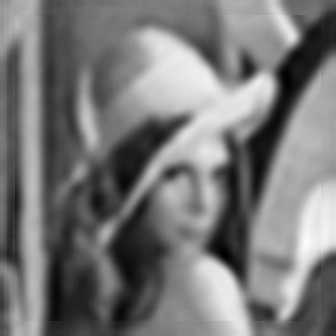

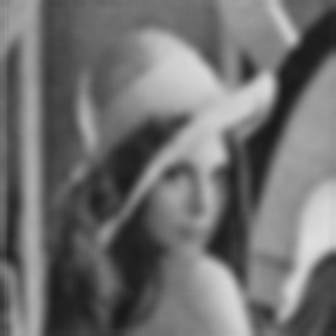

In [211]:
deg=cv2.imread('/content/drive/MyDrive/Noisy-blurred-Lena-image-7-7-uniform-blur-10-dB-uniform-noise.png',0).astype('float')
deg=np.clip(cv2.GaussianBlur(deg,(13,13),10).astype('float'),0,255)
pred=deg.copy()
for i in range(W//2,deg.shape[0]-W//2):

    for j in range(W//2,deg.shape[1]-W//2):
        x_input=deg[i-W//2:i+W//2+1,j-W//2:j+1+W//2].reshape(1,W*W) #Reshaping the WxW window into a 1 row 2-D array
        y_out=regressor.predict(x_input) #predicting the error using the Model
        pred[i,j]+=y_out #Adding the predicted error to the pixel value

pred=((pred-np.min(pred))/np.max(pred))*255 #linear function ranging from 0-255
cv2_imshow(pred)
cv2_imshow(deg)

#Sources of inspiration and information
I was inspired by the book written by Digital Image Processing by Rafael C. GONZALES and Richard E. Woods for creating a Guassian Degradation Function and using Wiener Filtering.I also used the Hints provided by Sir on Teams.